In [1]:
%matplotlib inline

import os
import shutil  
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imsave

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, UpSampling2D
from keras.layers import Dropout, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow
from keras import backend
config = tensorflow.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tensorflow.Session(config=config) 
backend.set_session(sess)

np.random.seed(42)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [20]:
imgdatagen = ImageDataGenerator(rescale= 1./255)

seed = 1
img_shape = 224

image_generator = imgdatagen.flow_from_directory(
    'data/ADE20K_formated/train/img/',
    batch_size = 1,
    class_mode=None,
    target_size=(img_shape, img_shape),
    seed=seed)

mask_generator = imgdatagen.flow_from_directory(
    'data/ADE20K_formated/train/mask/',
    batch_size = 1,
    class_mode=None,
    target_size=(img_shape, img_shape),
    seed=seed)

train_generator = zip(image_generator, mask_generator)

Found 8298 images belonging to 1 classes.
Found 8298 images belonging to 1 classes.


In [21]:
vgg = VGG16(input_shape=(img_shape, img_shape, 3), include_top=False, weights='imagenet')

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
model = Sequential()
model.add(vgg)

model.add(UpSampling2D(2, interpolation='bilinear'))
model.add(Conv2D(512, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(512, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(512, (3, 3), padding="same", activation='relu'))

model.add(UpSampling2D(2, interpolation='bilinear'))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))

model.add(UpSampling2D(2, interpolation='bilinear'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))

model.add(UpSampling2D(2, interpolation='bilinear'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))

model.add(UpSampling2D(2, interpolation='bilinear'))
model.add(Conv2D(3, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(3, (3, 3), padding="same", activation="softmax"))

In [28]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 512)       2359808   
_________________________________________________________________
up_sampling2d_22 (UpSampling (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 256)      

In [29]:
model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=8298, verbose=1)

Epoch 1/10


ValueError: Error when checking target: expected conv2d_65 to have shape (224, 224, 1) but got array with shape (224, 224, 3)

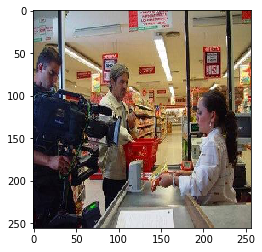

In [15]:
from keras.preprocessing import image
img_path = 'data/ADE20K_formated/train/img/img/00018985.jpg'
img = image.load_img(img_path, target_size=(256,256))
img = image.img_to_array(img) / 255.
img = np.expand_dims(img, axis=0)
plt.imshow(img[0])
plt.show()

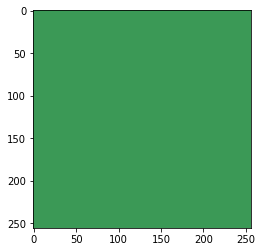

In [16]:
plt.imshow(model.predict(img)[0])